In [1]:
from IPython.display import clear_output
!pip install labml_nn
!pip install transformers
clear_output()

In [ ]:
from unet import *
from labml_nn.diffusion.ddpm.utils import gather
from typing import List
import torch
import torch.utils.data
import torchvision
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import torchvision
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BartTokenizer, BartModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (1) Data

In [ ]:
def show_images(dataset, num_samples, num_rows):
    plt.figure(figsize=(10, 10))
    ids = np.random.randint(0, len(dataset), num_samples)
    for i, idx in enumerate(ids):
        img = dataset[idx][0]
        if(type(img)==torch.Tensor):
            img = img.numpy().transpose((1, 2, 0))
        if i == num_samples:
            break
        plt.subplot(num_rows, num_samples // num_rows, i + 1)
        plt.imshow(img)
        plt.axis('off')


In [ ]:
def rgba2rgb(image_pil, background=(255, 255, 255)):
	rgba = np.array(image_pil)
	row, col, ch = rgba.shape
	if ch == 3:
		return image_pil
	assert ch == 4, 'RGBA image has 4 channels.'
	rgb = np.zeros((row, col, 3), dtype='float32')
	r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
	a = np.asarray(a, dtype='float32') / 255.0
	R, G, B = background
	rgb[:,:,0] = r * a + (1.0 - a) * R
	rgb[:,:,1] = g * a + (1.0 - a) * G
	rgb[:,:,2] = b * a + (1.0 - a) * B
	return Image.fromarray(np.uint8(rgb), 'RGB')

In [ ]:
def custom_loader(path):
    return Image.open(path).convert("RGBA")

## (2) Diffusion model

In [ ]:
class DiffusionModel:

  def __init__(
      self,
      dataloader: torch.utils.data.DataLoader,
      image_channels: int = 3,
      image_size: int = 64,
      n_channels: int = 64,
      channel_multipliers: List[int] = [1, 2, 2, 4],
      is_attention: List[int] = [False, False, True, True],
      embedding_dim: int = 768,
      timesteps: int = 1000,
      batch_size: int = 10,
      n_samples: int = 4,
      learning_rate: float = 2e-5,
      epochs: int = 1000,
      optimizer: torch.optim.Adam = None,
      device: torch.device = None,
      diffusion: str = "linear",
  ):
      self.image_channels = image_channels
      self.image_size = image_size
      self.n_channels = n_channels
      self.channel_multipliers = channel_multipliers
      self.is_attention = is_attention
      self.embedding_dim = embedding_dim
      self.timesteps = timesteps
      self.batch_size = batch_size
      self.n_samples = n_samples
      self.learning_rate = learning_rate
      self.epochs = epochs
      self.optimizer = optimizer
      self.device = device
      self.diffusion = diffusion
      self.dataloader = dataloader

      if device == None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

      self.model = UNet(
          image_channels = self.image_channels,
          n_channels = self.n_channels,
          ch_mults = self.channel_multipliers,
          is_attn = self.is_attention,
          embedding_dim = self.embedding_dim,
      ).to(self.device)

      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

      # defining diffusion schedule
      if self.diffusion == "linear":
        self.beta = torch.linspace(0.0001, 0.02, self.timesteps).to(self.device)

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0).to(self.device)
        self.sigma2 = self.beta

      elif self.diffusion == "cosine": # doesnt work
        idk = lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
        betas = []
        for i in range(self.timesteps):
            t1 = i / self.timesteps
            t2 = (i + 1) / self.timesteps
            betas.append(min(1 - idk(t2) / idk(t1), 0.999))
        self.beta = torch.Tensor(betas).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0).to(self.device)
        self.sigma2 = self.beta

      # Tokenizer
      self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

      # Text embedding
      self.text_encoder = BartModel.from_pretrained('facebook/bart-base')

      print(f'Bart model embedding dim: {self.text_encoder.config.d_model}')

  # diffusion functinos
  def q_xt_x0(self, x0, t):
    mean = gather(self.alpha_bar, t) ** 0.5 * x0
    var = 1 - gather(self.alpha_bar, t)

    return mean, var

  def q_sample(self, x0, t, eps = None):
    if eps is None:
        eps = torch.randn_like(x0)

    mean, var = self.q_xt_x0(x0, t)
    return mean + (var ** 0.5) * eps

  @torch.no_grad()
  def p_sample(self, xt, t, context):

    eps_theta = self.model(xt, t, context)
    alpha_bar = gather(self.alpha_bar, t)
    alpha = gather(self.alpha, t)
    eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
    mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
    var = gather(self.sigma2, t)

    eps = torch.randn(xt.shape, device=xt.device)
    # Sample
    return mean + (var ** .5) * eps

  def show_tensor_image(self, image):
    image = image.cpu()
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda x: (x + 1) / 2),
        transforms.Lambda(lambda x: x.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda x: x * 255.),
        transforms.Lambda(lambda x: x.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


  def plot_samples(self, x):
    plt.figure(figsize=(10,10))

    num_samples = x.shape[0]
    num_rows = int(np.sqrt(num_samples))
    for i in range(num_samples):
        plt.subplot(num_rows, num_samples // num_rows, i + 1)
        self.show_tensor_image(x[i])

  def sim_forward_diff(self):
    # Simulate forward diffusion
    image = next(iter(self.dataloader))[0]

    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(self.timesteps/num_images)

    for idx in range(0, self.timesteps, stepsize):
        t = torch.Tensor([idx]).type(torch.int64).to(self.device)
        plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
        img = self.q_sample(image.to(self.device), t)
        self.show_tensor_image(img)

  def tokenize_prompt(self, prompts):
        '''
        Input: propmts; list of strings

        Output: tokens; [batch_size, seq_len]
        '''

        tokenized_context = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)
        context_ids = tokenized_context["input_ids"]
        return context_ids

  def embedd_prompt(self, prompts):
    context_ids = self.tokenize_prompt(prompts)

    # Get the embeddings
    embedded_text = self.text_encoder(context_ids)
    with torch.no_grad():
      sentence_embedding = embedded_text.last_hidden_state.mean(dim=1) #(batch_size, embedding_dim)
    return sentence_embedding.to(self.device)


  def get_loss(self, x0, context, noise = None):

    batch_size = x0.shape[0]
    t = torch.randint(0, self.timesteps, (self.batch_size,), device=x0.device, dtype=torch.long)

    if noise is None:
        noise = torch.randn_like(x0)

    xt = self.q_sample(x0, t, eps=noise)
    eps_theta = self.model(xt, t, context)

    # MSE loss
    return F.mse_loss(noise, eps_theta)


  @torch.no_grad()
  def sample(self, prompt):

    with torch.no_grad():
        x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                        device=self.device)


        prompt = [prompt] * self.n_samples

        sentence_embedding = self.embedd_prompt(prompt)

        # Remove noise for each timestep
        for t in reversed(range(0, self.timesteps)):

            x = self.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long), sentence_embedding)

        return x

  def train(self):
    pbar = tqdm(self.dataloader, mininterval=2 )
    sum_loss = 0
    for data, context in pbar:
        data = data.to(self.device)

        # remove dashes from context
        context = list(context)
        #modified_list = [s.replace("-", " ") for s in context]

        sentence_embedding = self.embedd_prompt(context)

        self.optimizer.zero_grad()

        loss = self.get_loss(data, sentence_embedding)
        sum_loss += loss.item()
        loss.backward()
        self.optimizer.step()

    return sum_loss

  def run(self, save_dir = None, model_name = None):
    loss_history = []
    if save_dir == None:
      print("Model won't be saved")

    for ep in range(self.epochs):
        sum_loss = self.train()

        # Save the model
        if save_dir != None:
          os.makedirs(save_dir, exist_ok=True)
          torch.save(self.model.state_dict(), save_dir + f"{model_name}.pth")
          print('saved model at ' + save_dir + f"{model_name}.pth")

        if ep%15 == 0:
          drive.mount('/content/drive') # drive je smece
          prompt = "jellyfish"
          samples = self.sample(prompt)
          self.plot_samples(samples)
          plt.show()

        print(f"Epoch {ep} | Loss: {sum_loss} ")
        loss_history.append(sum_loss)

    # plot loss history
    plt.plot(loss_history)
    plt.show()

In [ ]:
batch_size = 64
image_size = 64
image_channels = 3 #rGB
epochs = 1000
timesteps = 1000
n_samples = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

##Generating the dataset (optional)



In [ ]:
class CustomImageFolder(Dataset):
	def __init__(self, root_dir, transform=None):
		self.root_dir = root_dir
		self.transform = transform
		self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):
		img_path = self.image_paths[idx]
		image = Image.open(img_path).convert('RGBA')

		if self.transform:
			image = self.transform(image)

		filename = os.path.basename(img_path).split('.')[0]  # Filenames are like "image-imagedesc.jpg"
		filename = filename.replace('-', ' ')

		return image, filename

In [ ]:
image_dir = '/content/drive/MyDrive/Aleksa/emojis'

# define training dataset and data loader
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: rgba2rgb(img)),
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # Scales data into [0,1]
    transforms.Lambda(lambda x: (x * 2) - 1), # Scale between [-1, 1]
])

train_dataset = CustomImageFolder(root_dir=image_dir, transform=train_transform)
dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=0, drop_last=True)

In [ ]:
diff_model = DiffusionModel(
    dataloader,
    diffusion="linear",
    epochs=epochs,
    timesteps=timesteps,
    device=device,
    n_samples=n_samples,
    batch_size = batch_size,
    image_channels = image_channels
)

DownBlock: 64 -> 64 height: 64 width: 64
DownBlock: 64 -> 64 height: 64 width: 64
DownBlock: 64 -> 128 height: 32 width: 32
DownBlock: 128 -> 128 height: 32 width: 32
DownBlock: 128 -> 256 height: 16 width: 16
DownBlock: 256 -> 256 height: 16 width: 16
DownBlock: 256 -> 1024 height: 8 width: 8
DownBlock: 1024 -> 1024 height: 8 width: 8
Bart model embedding dim: 768


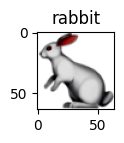

In [ ]:
for data, context in dataloader:
  plt.figure(figsize=(1,1))
  plt.title(context[0])
  plt.imshow(data[0].permute(1,2,0))
  plt.show()
  break

## Training

In [ ]:
save_dir = "/content/drive/MyDrive/Aleksa/diff_model/"

In [ ]:
diff_model.model.load_state_dict(torch.load('/content/drive/MyDrive/Aleksa/diff_model/model_1.pth', map_location=diff_model.device))
print("Loaded in Model")

Loaded in Model


100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


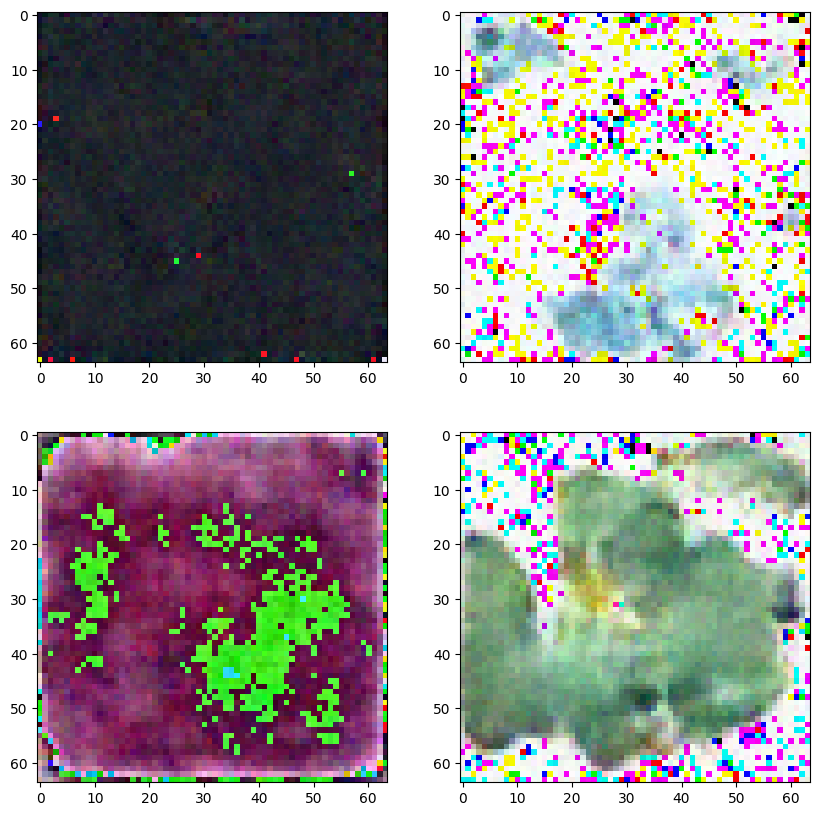

Epoch 0 | Loss: 2.245879912748933 


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 1 | Loss: 1.784076003357768 


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 2 | Loss: 1.569329566322267 


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 3 | Loss: 1.4623089907690883 


100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 4 | Loss: 1.4266426898539066 


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 5 | Loss: 1.328182383440435 


100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 6 | Loss: 1.2981531480327249 


100%|██████████| 50/50 [01:49<00:00,  2.19s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 7 | Loss: 1.272162463515997 


100%|██████████| 50/50 [01:49<00:00,  2.19s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 8 | Loss: 1.2325930474326015 


100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 9 | Loss: 1.1856383802369237 


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 10 | Loss: 1.1970965545624495 


100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 11 | Loss: 1.1339739887043834 


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 12 | Loss: 1.1791598852723837 


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 13 | Loss: 1.142081287689507 


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 14 | Loss: 1.1661854600533843 


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


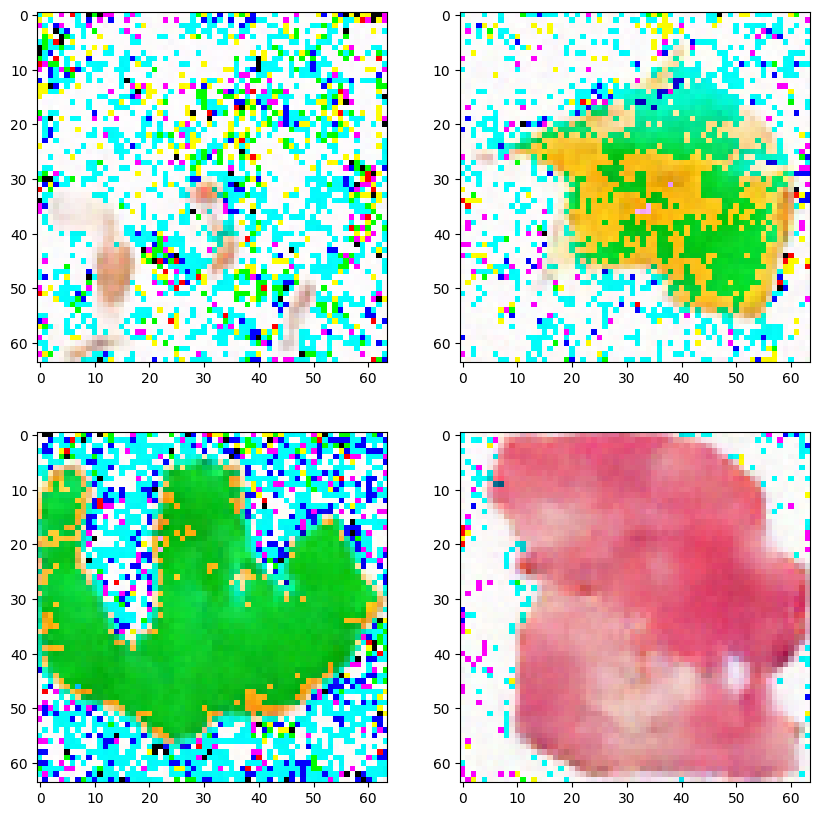

Epoch 15 | Loss: 1.1648805201984942 


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 16 | Loss: 1.1705923918634653 


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 17 | Loss: 1.0769103467464447 


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 18 | Loss: 1.1407112209126353 


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 19 | Loss: 1.019022206775844 


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 20 | Loss: 0.9986725663766265 


100%|██████████| 50/50 [01:49<00:00,  2.18s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 21 | Loss: 1.0823337961919606 


100%|██████████| 50/50 [01:48<00:00,  2.18s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 22 | Loss: 1.0531443418003619 


100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 23 | Loss: 0.9318436058238149 


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 24 | Loss: 0.9804490306414664 


100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 25 | Loss: 1.044796689413488 


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 26 | Loss: 1.0088330525904894 


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 27 | Loss: 0.9658486749976873 


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 28 | Loss: 1.0014630611985922 


100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth
Epoch 29 | Loss: 1.0773768927901983 


100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


saved model at /content/drive/MyDrive/Aleksa/diff_model/model_1.pth


KeyboardInterrupt: ignored

In [ ]:
diff_model.run(save_dir, model_name = 'model_1')

In [ ]:
prompt = "cold face"
samples = diff_model.sample(prompt)
diff_model.plot_samples(samples)
plt.show()